In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import time

In [7]:
#Load Data
data=pd.read_csv('July_2016_MDincome.csv')

In [216]:
#Helper funtions: Assign Labels to the volume of bikes going through a station
def assign_volume(volume_lower,volume_upper,volume):
    if volume<volume_lower:
        return('Low Volume')
    elif volume>volume_upper:
        return('High Volume')
    else:
        return('Average Volume')
#Assign the label (volume quantity, and end-start ratio)
def assign_labels(data,median_volume):
    volume=data['num_end_proportion'].median()+data['num_start_proportion'].median()
    volume_upper=median_volume+0.1
    volume_lower=median_volume-0.1
    labels=dict()
    if abs(data['end_start_ratio'].median())<0.55:
        labels['Flux']='Equal Traffic'
    elif 0.55<data['end_start_ratio'].median()<1.55 :
        labels['Flux']='Slightly More Incoming Traffic'
    elif -1.55<data['end_start_ratio'].median()<-0.55 :
        labels['Flux']='Slightly More Outgoing Traffic'
    elif data['end_start_ratio'].median()<-1.55 :
        labels['Flux']='Heavily More Outgoing Traffic'
    elif data['end_start_ratio'].median()>1.55 :
        labels['Flux']='Heavily More Incoming Traffic'
    else:
        labels['Flux']='Equal Traffic'
    labels['Volume']=assign_volume(volume_lower,volume_upper,volume)
    description=labels['Volume'] +' ' + labels['Flux']
    return(description)
    

In [217]:
#This function takes in the data for the month, and a list of hours that you want to cluster about,
#and then gives you the optimal number of clusters, clusters it , and spits out a data-frame giving of starts, and ends
#at each station, and their associated labels. (By plot). It also outputs the numpy array which you will want to run the 
# k-means clustering on. In any case, the optimal number of clusters with my method is 5 for most data sets, so I cluster for you here.

def find_labels(month_data,hour,title='label',num_clusters=5):
    #Get the dataframe with the entires only corresponding to input hours.
    test_data=month_data[month_data['time'].isin(hour)]
    test_data=test_data[['start station id', 'end station id']]
    #Get a comprehensive list of all the stations, and their associated information (id, latitude, longitude)
    location_data=month_data[['end station id', 'end station latitude', 'end station longitude']]
    location_data=location_data.drop_duplicates()
    location_data=location_data.sort_values('end station id')
    location_data.index=location_data['end station id']
    #Create two data frames with the number of bikes taken out, and put in at each station at the given hours.
    starts=test_data['start station id'].value_counts()
    ends=test_data['end station id'].value_counts()
    start_frame=pd.DataFrame(starts)
    start_frame['num_starts']=start_frame['start station id']
    start_frame['start station id']= start_frame.index
    end_frame=pd.DataFrame(ends)
    end_frame['num_ends']=end_frame['end station id']
    end_frame['end station id']= end_frame.index
    #Join the end and start data with the original data frame according to station id
    location_data=location_data.join(end_frame,how='left',lsuffix='',rsuffix='_right')
    location_data=location_data.join(start_frame,how='left',lsuffix='',rsuffix='_right')
    #Create a data frame to use for clustering
    real_loc_data=location_data[['num_ends','num_starts','end station latitude', 'end station longitude']]
    real_loc_data=real_loc_data.fillna(value=0)
    division_start=np.array(real_loc_data['num_starts'])
    division_end=np.array(real_loc_data['num_ends'])
    #Create a ratio of starts/ends of each station. I used the log because k-means clusters on Euclidean distance, so smaller
    #ratios would be discounted in a standard clustering algorithim. I multiplied this by a factor of 2.5 (gives best clusters)
    #to have a bigger seperation of non-distinct values (artificial seperation of values)
    division=np.log(np.divide(division_end,division_start))
    real_loc_data['end_start_ratio']=2.5*division
    real_loc_data=real_loc_data.fillna(value=0)
    real_loc_data['end_start_ratio']=real_loc_data['end_start_ratio'].replace(float('inf'),3)
    real_loc_data['end_start_ratio']=real_loc_data['end_start_ratio'].replace(float('-inf'),-3)
    #Once again, since k-means clusters on Euclidean Distance, one needs to scale the starts and ends so that they are roughly(..?)
    # on the same order of magnitude as the ratios. So I divided the end and starts not by their max, since those would give all very small values
    #, but by the 85th percentile values so the really big values would still be really big, and small values would be very small
    # I multiplied the end proportion by a factor of 1.25 for the best seperation. 
    real_loc_data['num_end_proportion']=1.25*real_loc_data['num_ends']/np.percentile(real_loc_data['num_ends'],85)
    real_loc_data['num_start_proportion']=1.25*real_loc_data['num_starts']/np.percentile(real_loc_data['num_starts'],85)
    real_loc_data['num_start_proportion']=real_loc_data['num_start_proportion'].replace(float('-inf'),-15)
    real_loc_data['num_end_proportion']=real_loc_data['num_end_proportion'].replace(float('-inf'),-15)
    trip=np.array(real_loc_data[['end_start_ratio','num_end_proportion','num_start_proportion']])
    #Create an elbow graph to determine the optimal number of clusters
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(trip)
        kmeanModel.fit(trip)
        distortions.append(sum(np.min(cdist(trip, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / trip.shape[0])
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    #Create clusters, and attach to each station a label
    kmeanmodel = KMeans(n_clusters=num_clusters, random_state=0).fit(trip)
    labels=kmeanmodel.labels_
    label_frame=pd.DataFrame(labels)
    real_loc_data[title]=labels
    volume=real_loc_data['num_start_proportion'].median()+real_loc_data['num_end_proportion'].median()
    for i in range(num_clusters):
        labeled_data=real_loc_data[real_loc_data[title]==i]
        descriptor=assign_labels(labeled_data,volume)
        real_loc_data[title]=real_loc_data[title].replace(i,descriptor)
    real_loc_data=real_loc_data.drop(labels=['num_ends','num_starts','end_start_ratio','num_end_proportion','num_start_proportion'],axis=1)
    return(real_loc_data)


C:\Users\Bruce\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Bruce\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Bruce\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


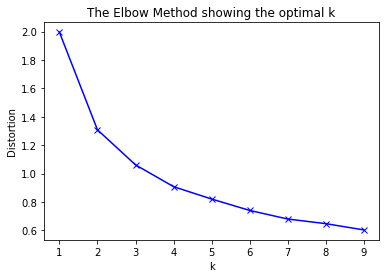

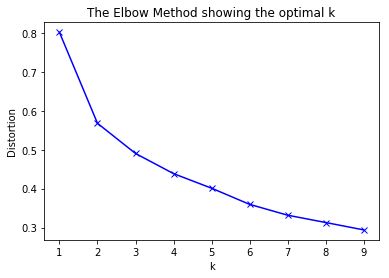

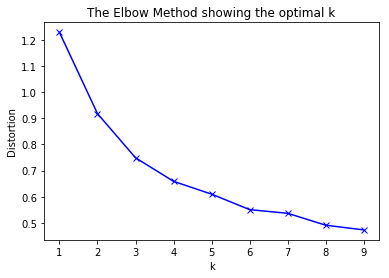

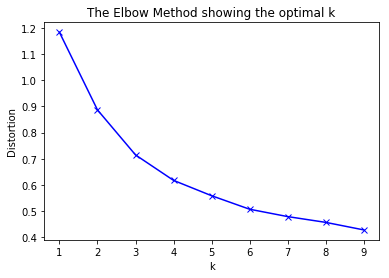

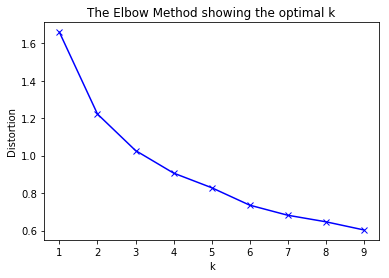

In [222]:
#Creating the clusters for different times
real_loc_data=find_labels(data,['600','700','800','900','1000'],title='Morning Label')
real_loc_data2=find_labels(data,['1100','1200','1300','1400'],title='Afternoon Label')
real_loc_data3=find_labels(data,['1500','1600','1700','1800','1900'],title='Evening Label')
real_loc_data4=find_labels(data,['2000','2100','2200','2300','0'],title='Night Label')
real_loc_data5=find_labels(data,['100','200','300','400','500'],title='Early Morning Label')

In [227]:
#Merge the DataFrames together to create a whole day cluster labels to see traffic patterns. 
merged_id=real_loc_data.merge(real_loc_data2,left_index=True,right_index=True)
merged_id=merged_id.merge(real_loc_data3,left_index=True,right_index=True)
merged_id=merged_id.merge(real_loc_data4,left_index=True,right_index=True)
merged_id=merged_id.merge(real_loc_data5,left_index=True,right_index=True)
merged_id=merged_id[['Early Morning Label', 'Morning Label', 'Afternoon Label', 'Evening Label', 'Night Label', 'end station latitude', 'end station longitude']]
merged_id.to_csv('July_Station_Labels.csv')